# LZIFU: properties of the whole sample

In [1]:
## Imports
import sys
import os 
import numpy as np
import pandas as pd
from astropy.visualization import hist

from spaxelsleuth.loaddata.lzifu import load_lzifu_galaxy
from spaxelsleuth.loaddata.sami import load_sami_galaxies
from spaxelsleuth.plotting.plot2dmap import plot2dmap
from spaxelsleuth.plotting.sdssimg import plot_sdss_image
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram, plot_BPT_lines
from spaxelsleuth.plotting.plottools import vmin_fn, vmax_fn, label_fn, cmap_fn
from spaxelsleuth.plotting.plottools import component_colours
from spaxelsleuth.plotting.plotgalaxies import plot2dscatter, plot2dhistcontours

import matplotlib
from matplotlib import rc, rcParams
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

rc("text", usetex=False)
rc("font",**{"family": "serif", "size": 14})
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.format"] = "pdf"
plt.ion()
plt.close("all")

In [10]:
# Load the SAMI sample
df_sami = load_sami_galaxies(ncomponents="recom",
                             bin_type="default",
                             eline_SNR_min=5, 
                             vgrad_cut=False,
                             correct_extinction=False,
                             sigma_gas_SNR_cut=True)

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Load each galaxy; merge into a single DataFrame

In [2]:
# List all galaxies we have LZIFU data for
lzifu_data_path = "/priv/meggs3/u5708159/LZIFU/products/"
gals_lzifu = [int(f.split("_merge_lzcomp.fits")[0]) for f in os.listdir(lzifu_data_path) if f.endswith("merge_lzcomp.fits") and not f.startswith("._")]    
gals_shortlist = [64553, 106717, 30346, 41144, 609396, 9388000219, 144491, 106042, 240108, 184368, 8703, 544958, 460374, 537361, 144402, 204799, 463668, 85416, 463288, 511867, 24013, 561020, 144239, 298666, 288364, 176955, 84107, 585386, 99349, 287824, 610398, 551202, 240449, 55150, 69620, 534753, 14812, 545925, 105597, 3630097, 8353, 77754, 220439, 383318, 618116, 144051, 278548, 396833, 238358, 485834, 518782, 622744, 143814, 106376, 623432, 221375, 296829, 9091700139, 209698]
gals_good = [g for g in gals_shortlist if g in gals_lzifu]

In [12]:
df = None
for gal in gals_good:
    # Load LZIFU data
    df_gal = load_lzifu_galaxy(gal=gal, bin_type="default", ncomponents="recom",
                       eline_SNR_min=5,
                       sigma_gas_SNR_cut=True,
                       vgrad_cut=False,
                       stekin_cut=False)
    if df is not None:
        df = pd.concat([df, df_gal], ignore_index=True)
    else:
        df = df_gal

df.loc[df["Number of components"] == 0, "Number of components"] = np.nan
        

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


### Histograms of line ratios (and other properties) of the 2nd component compared to the 0th component 

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


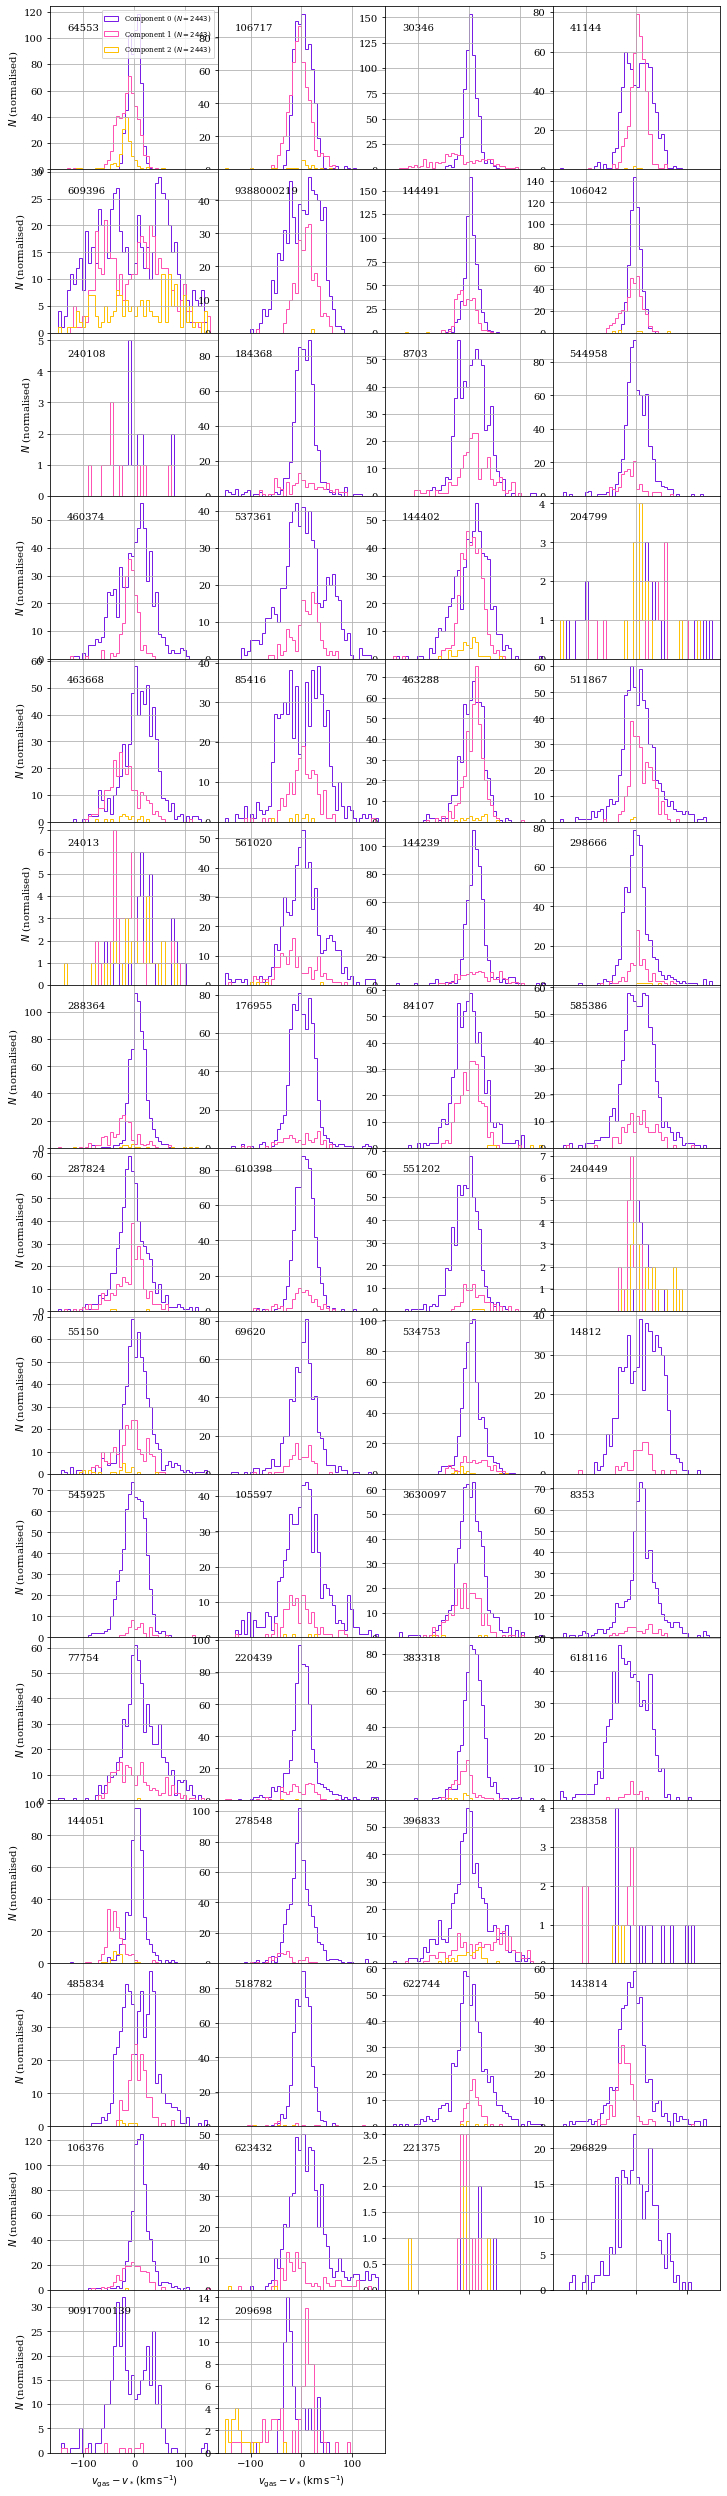

In [15]:
gals = df["catid"].unique()

ncols = 4
nrows = int(np.ceil(len(gals) / float(ncols)))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(3 * ncols, 3 * nrows))
fig.subplots_adjust(wspace=0, hspace=0)

col = "v_gas - v_*"
for gal, ax in zip(gals, axs.flat):
    # Load LZIFU data
    df_gal = df[df["catid"] == gal]
    
    # Histogram
    for ii in range(3):
        ax.hist(df_gal[f"{col} (component {ii})"], histtype="step", density=False,
                color=component_colours[ii], bins=50, range=(-150, +150),
                label=f"Component {ii} ($N = {df_gal.shape[0]:d}$)")
    ax.text(s=gal, y=0.9, x=0.1, verticalalignment="top", horizontalalignment="left", transform=ax.transAxes)

axs[0][0].legend(loc="upper right", fontsize="x-small")
for cc in range(ncols):
    axs[-1][cc].set_xlabel(label_fn(col))
for rr in range(nrows):
    axs[rr][0].set_ylabel(r"$N$ (normalised)")
for ax in axs.flat:
    ax.grid()
for ax in axs.flat[len(gals):]:
    ax.set_visible(False)
    


### 2D maps: is there  a correlation between number of components and SFR or $\Sigma_{\rm SFR}$?

/home/u5708159/python/Modules/spaxelsleuth/plotting/plot2dmap.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gal["x, y (pixels)"] = list(zip(df_gal["x (projected, arcsec)"] / as_per_px, df_gal["y (projected, arcsec)"] / as_per_px))
/home/u5708159/python/Modules/spaxelsleuth/plotting/plot2dmap.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gal["x, y (pixels)"] = list(zip(df_gal["x (projected, arcsec)"] / as_per_px, df_gal["y (projected, arcsec)"] / as_per_px))
/pkg/linux/anaconda-20191122/an

/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/u5708159/python/Modules/spaxelsleuth/loaddata/linefns.py:78: RuntimeWarning: invalid value encountered in add
  return -0.943 * ratio_y_vals**4 - 0.450 * ratio_y_vals**3 + 0.408 * ratio_y_vals**2 - 0.610 * ratio_y_vals - 0.025


/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
/pkg/linux/anaconda-20191122/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/pkg/linux/anaconda-20191122/anaconda3/lib/python

AssertionError: df_gal contains must only contain one galaxy!

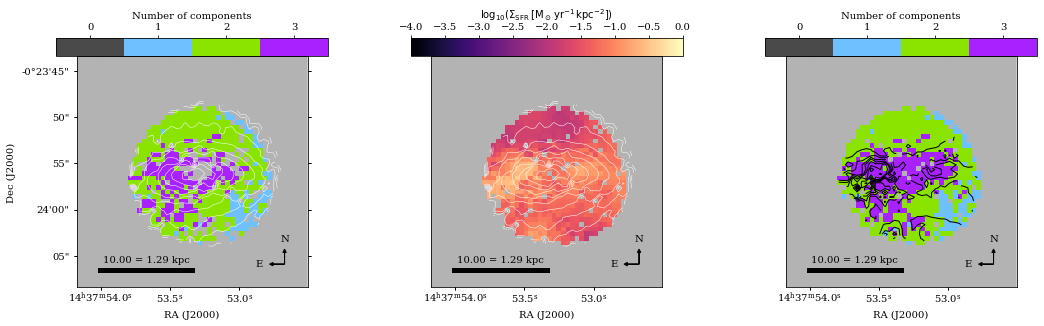

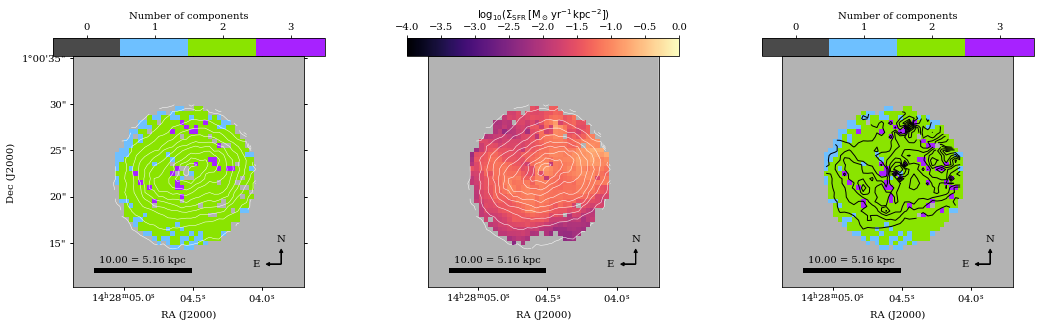

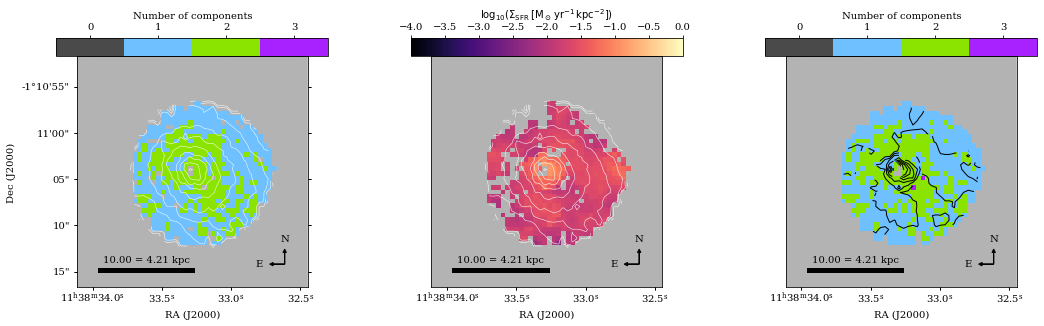

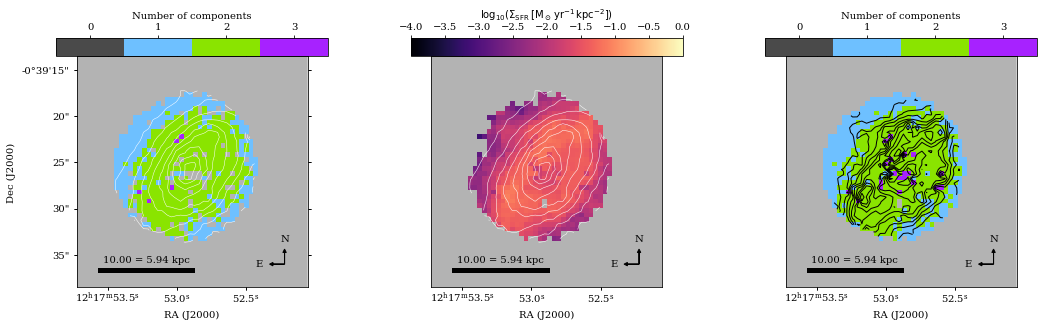

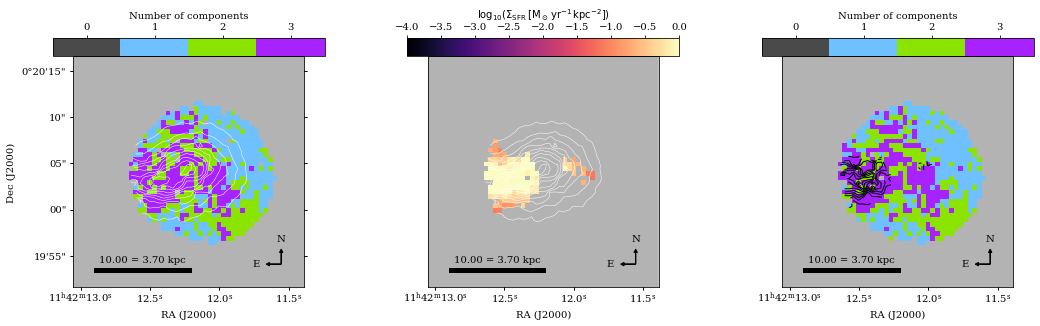

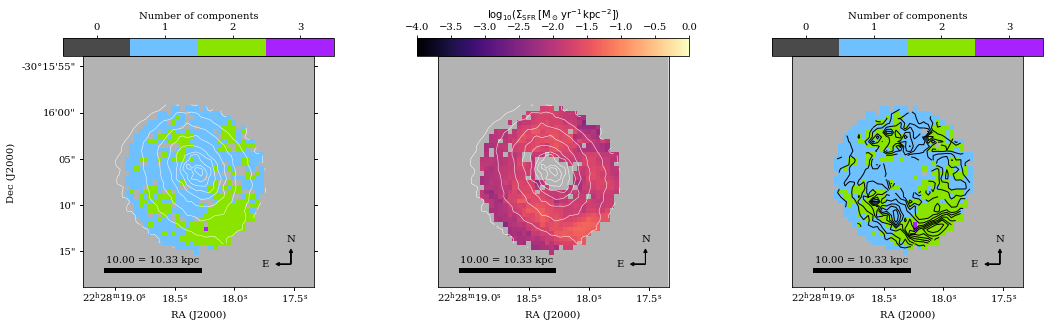

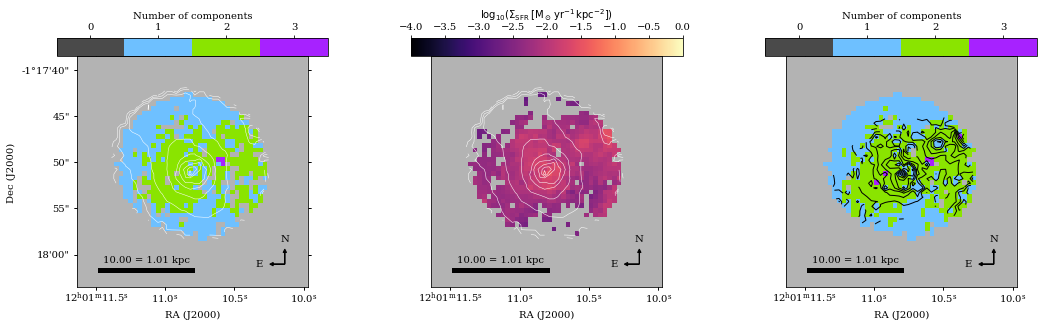

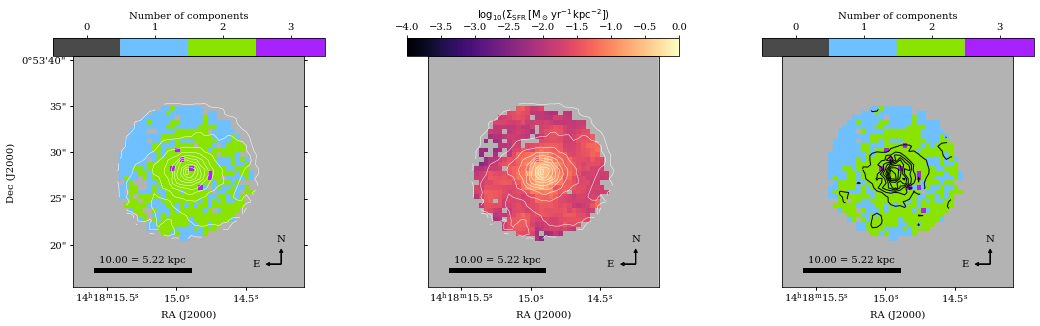

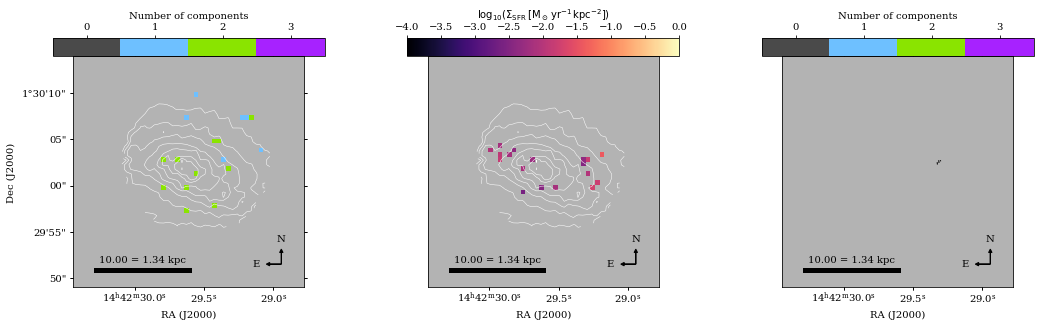

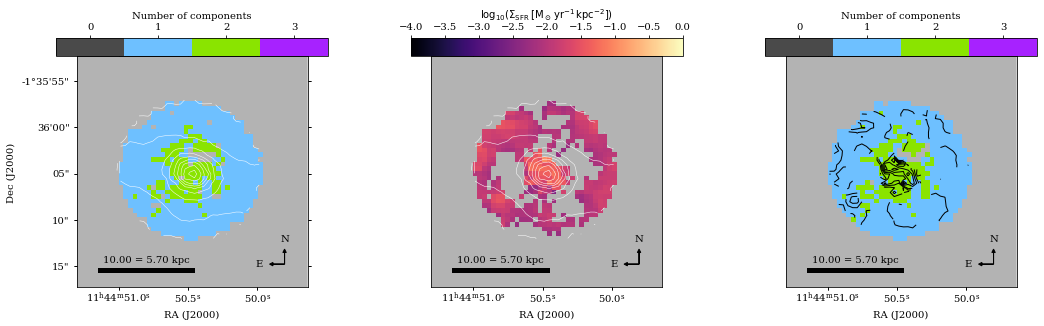

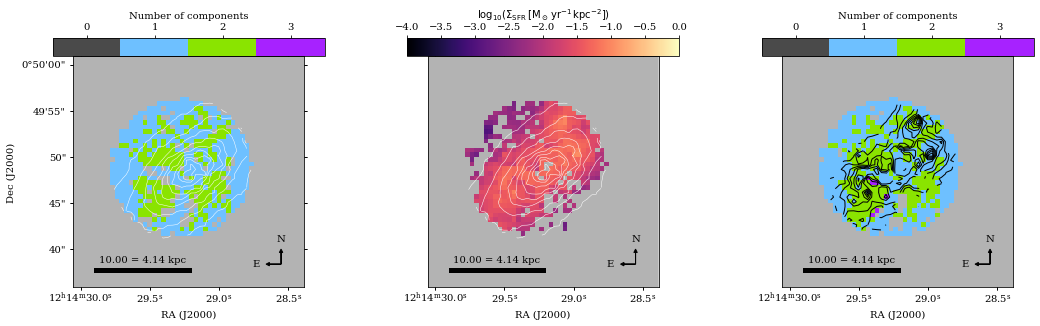

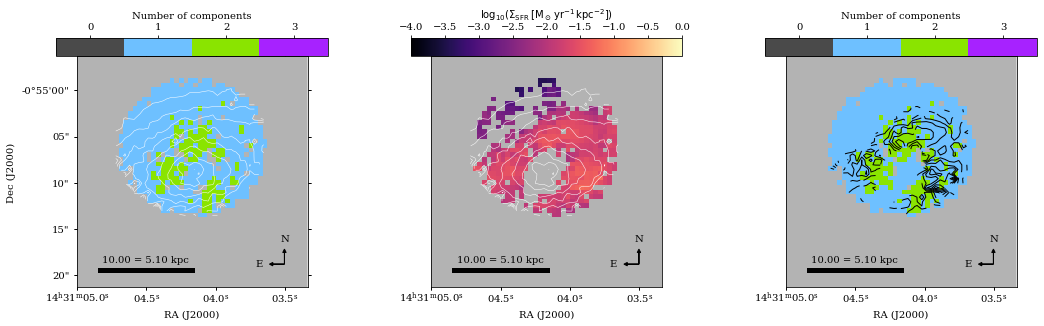

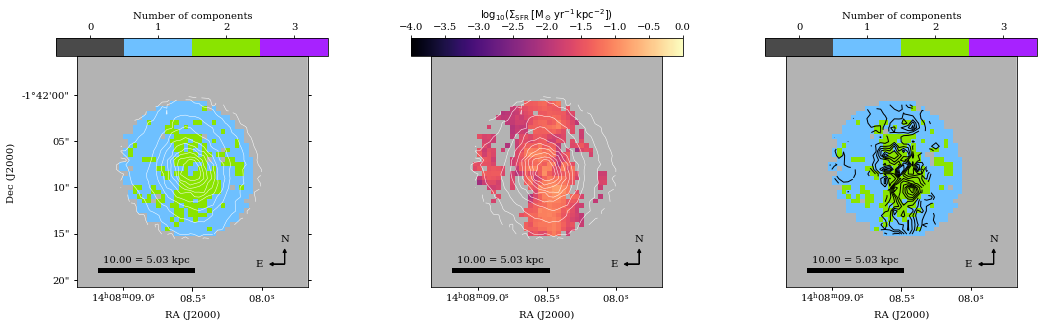

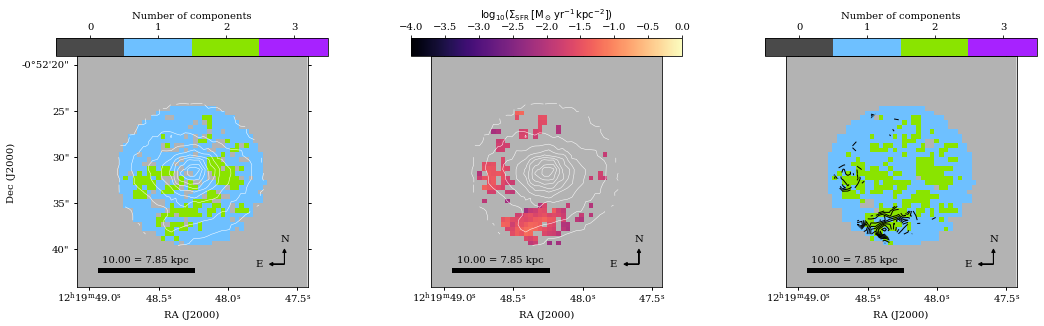

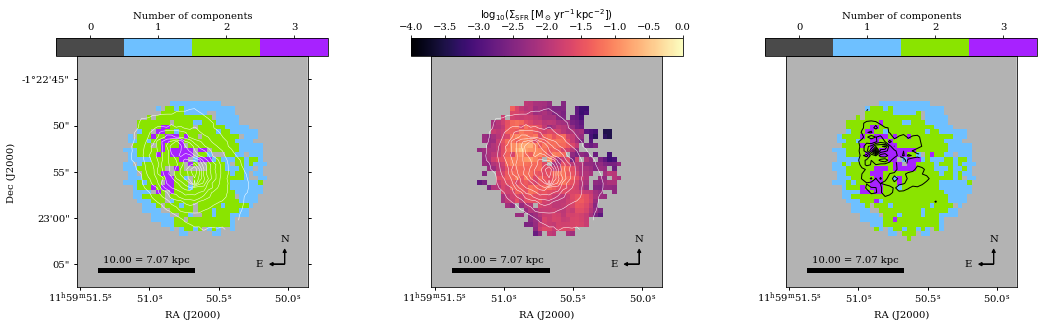

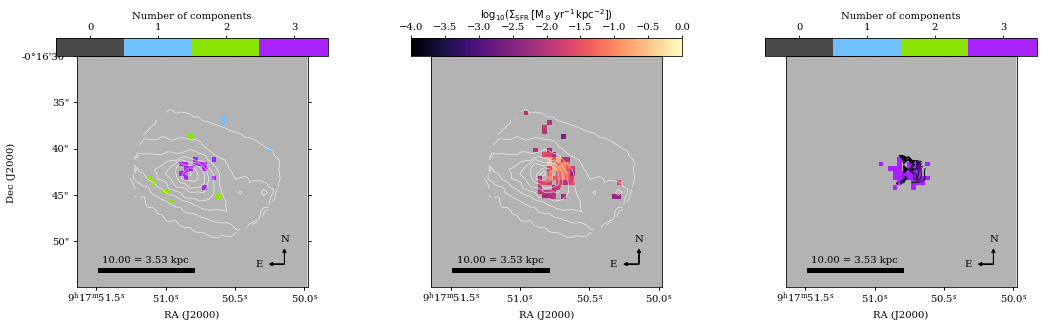

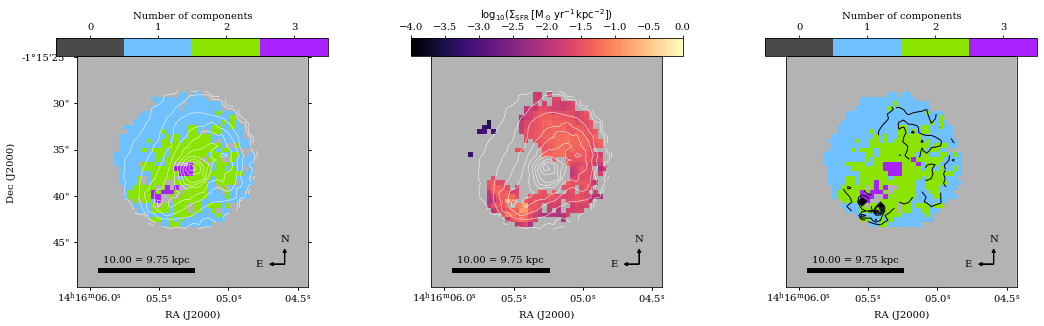

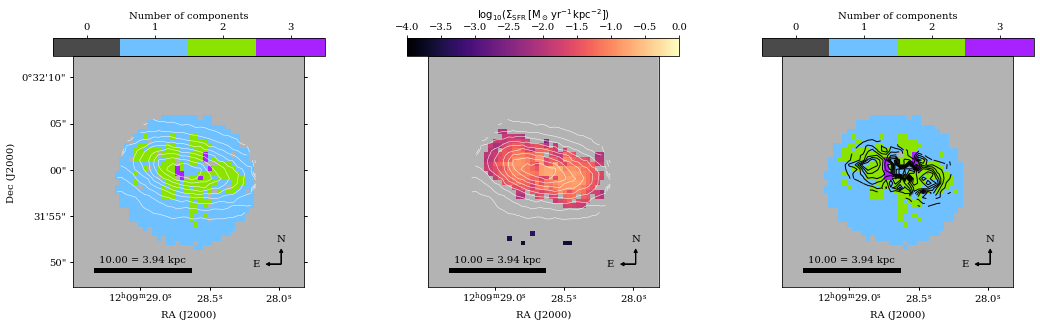

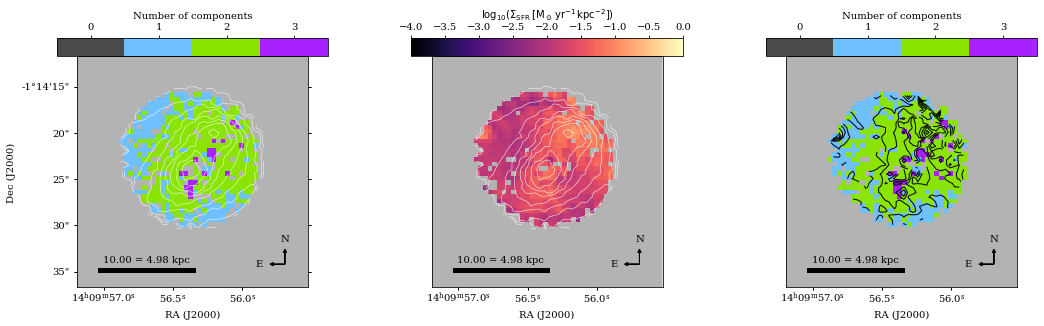

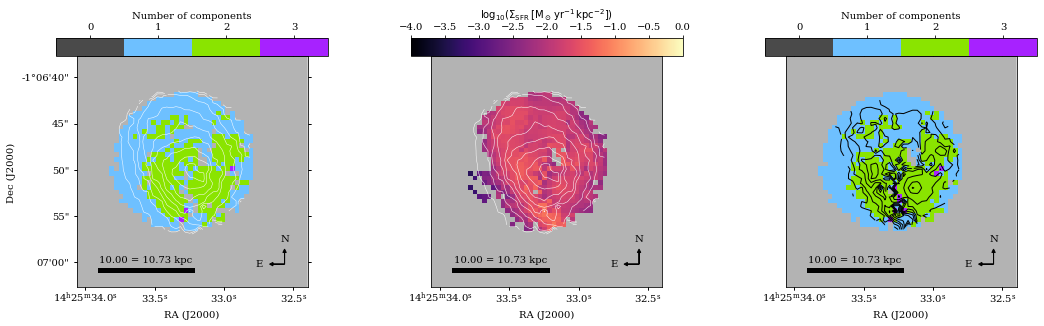

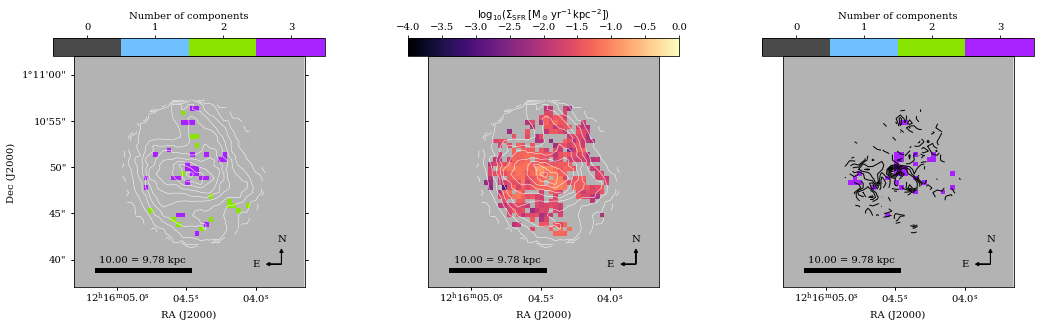

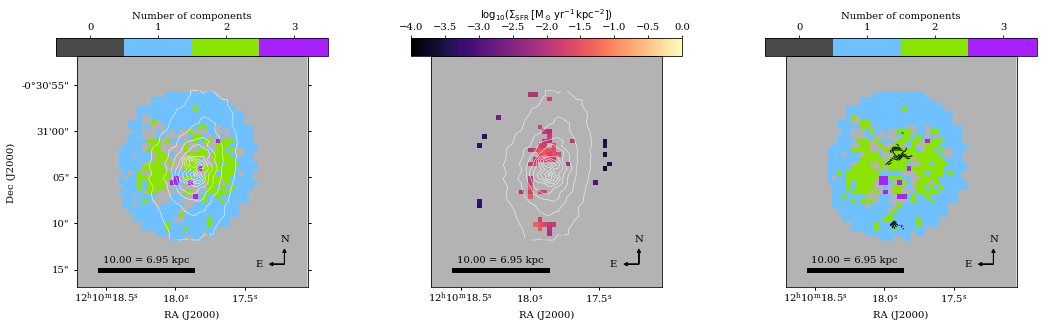

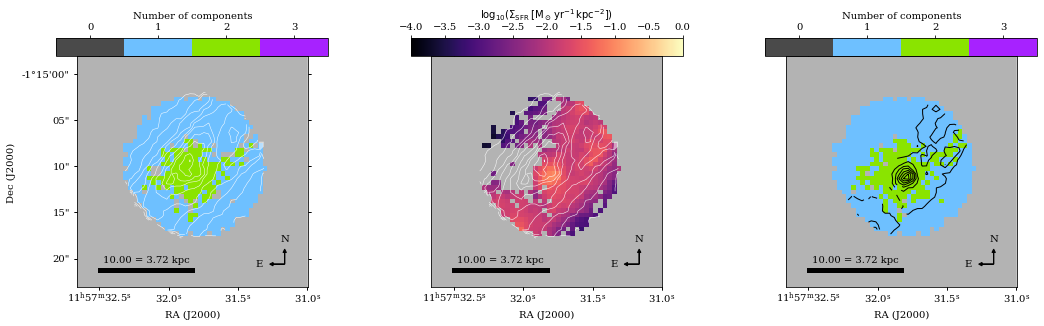

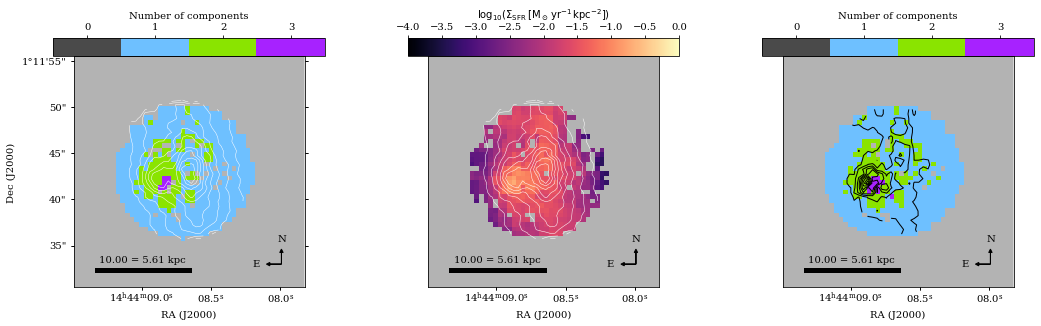

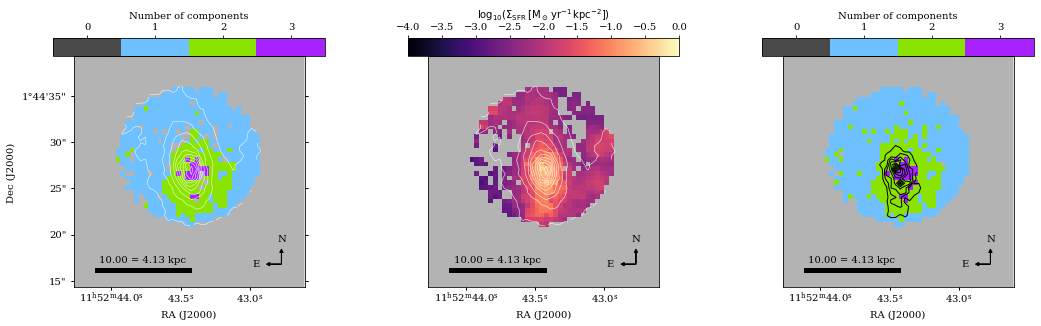

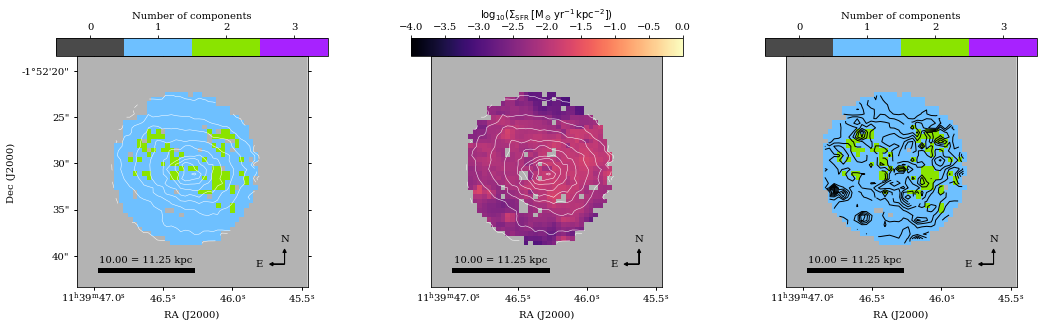

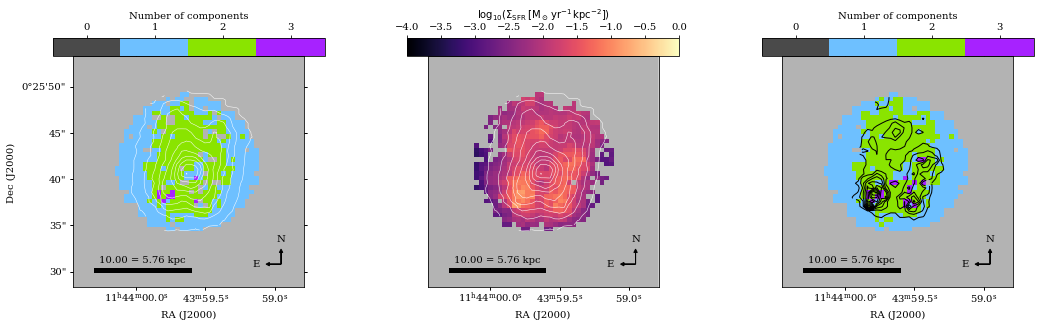

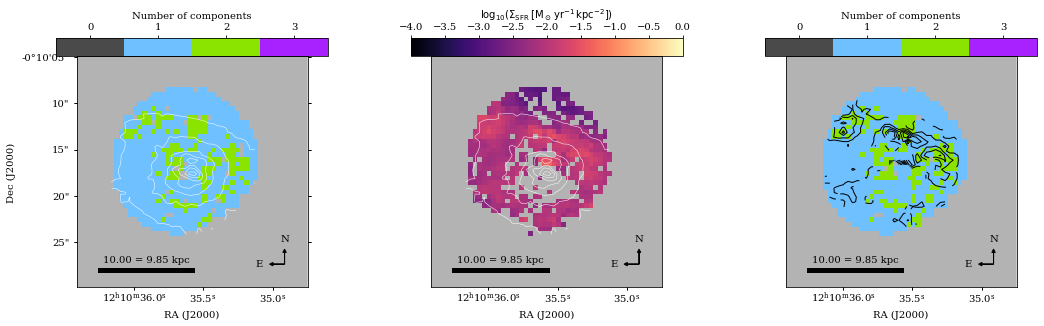

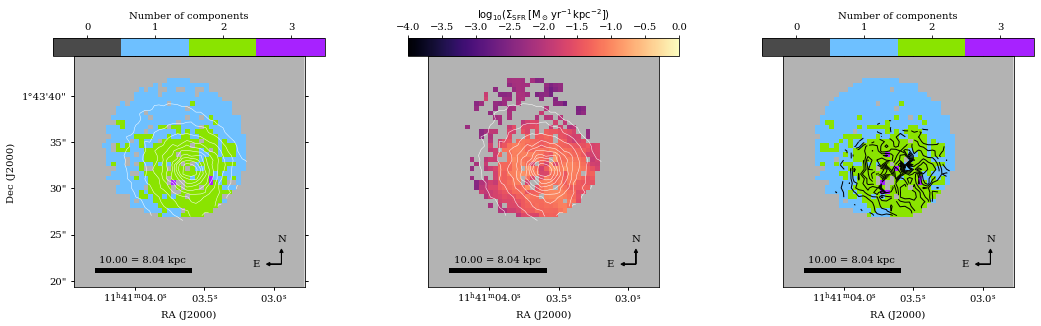

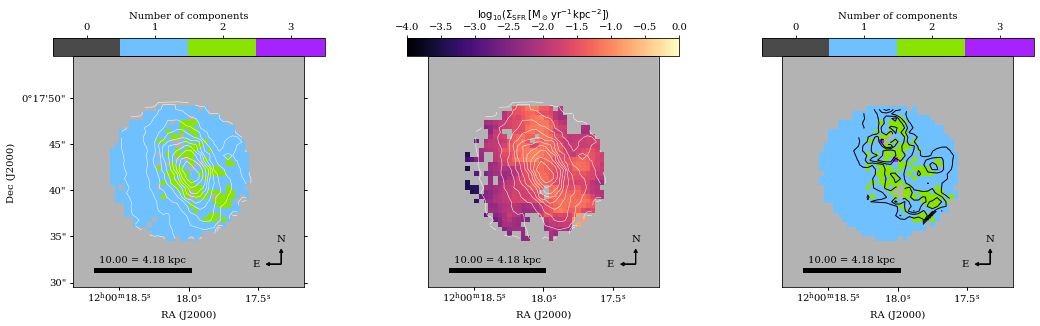

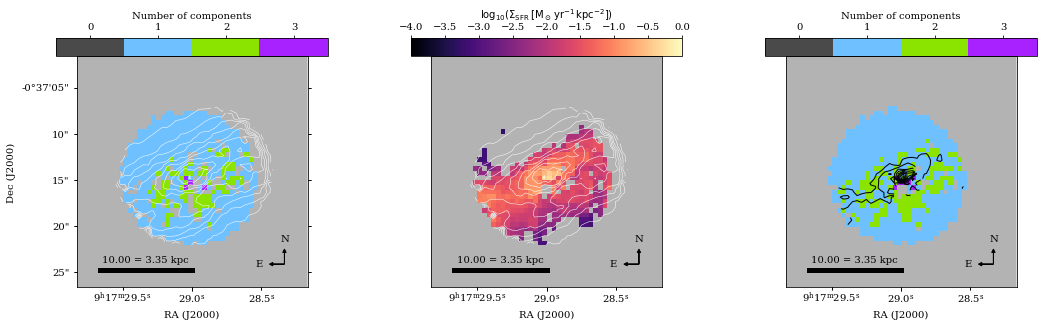

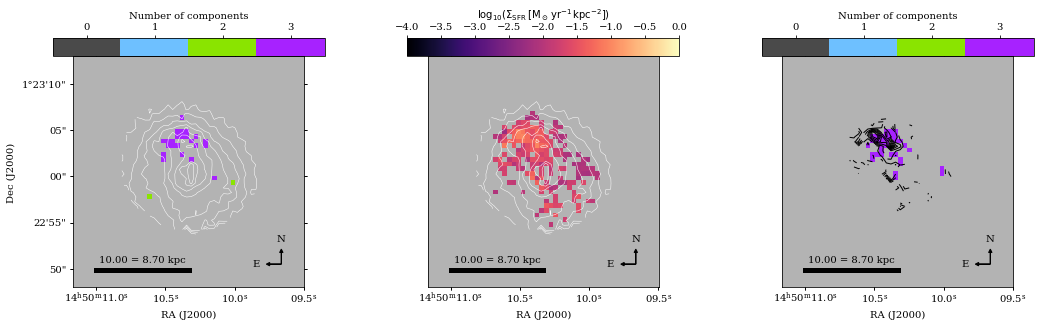

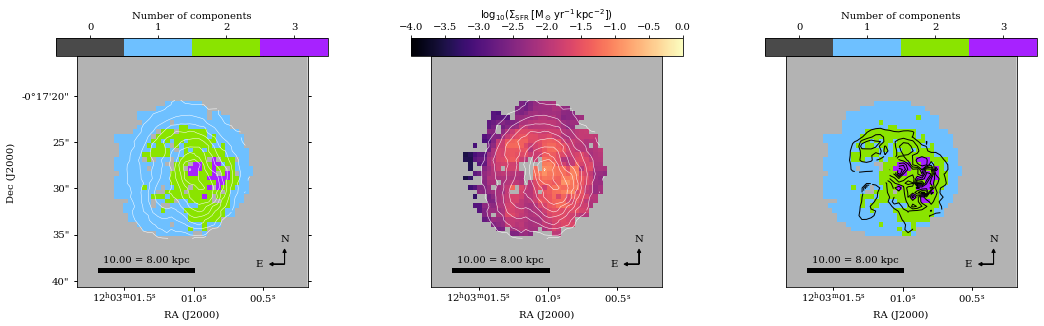

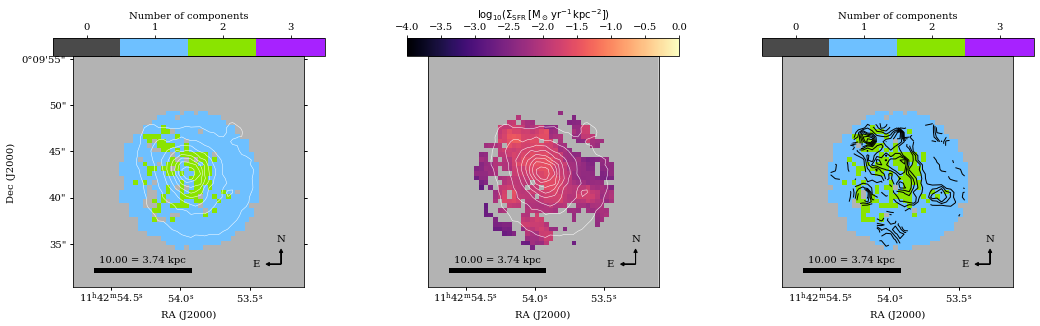

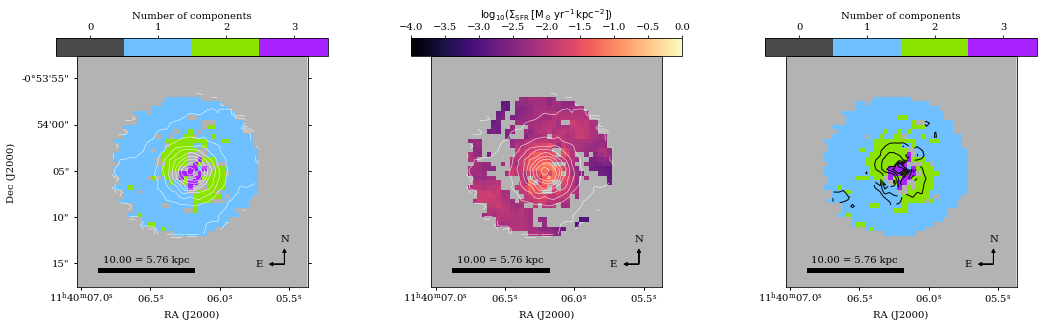

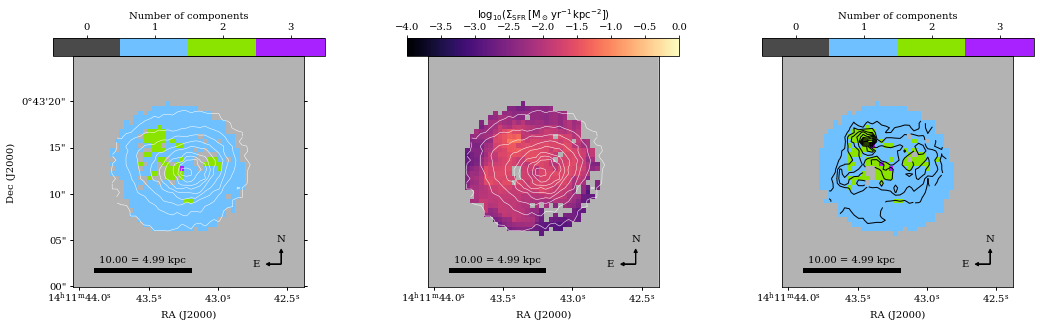

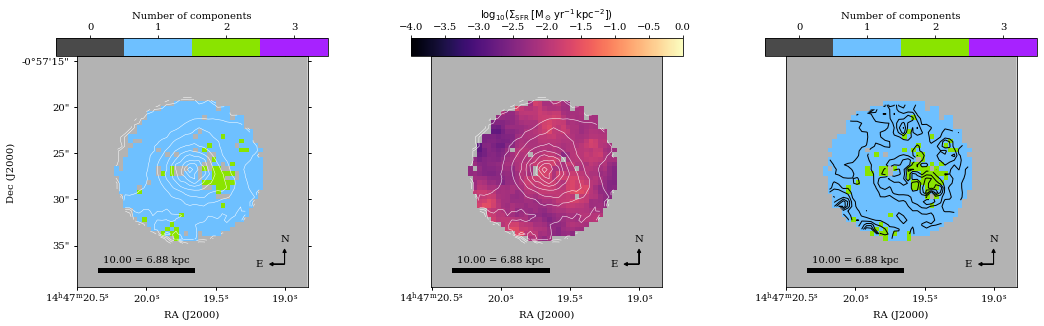

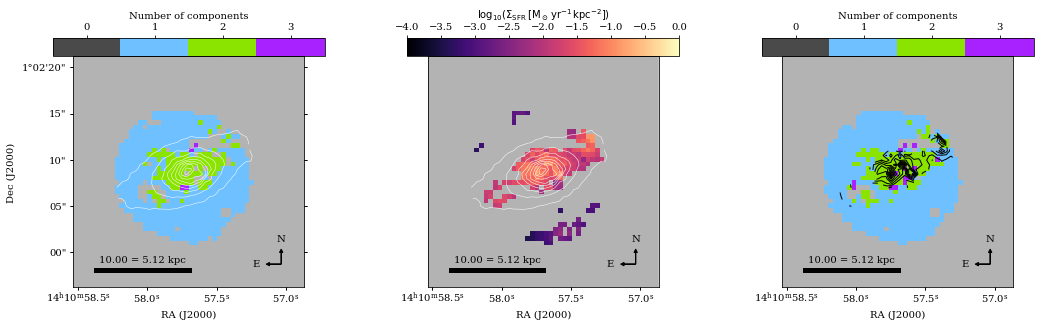

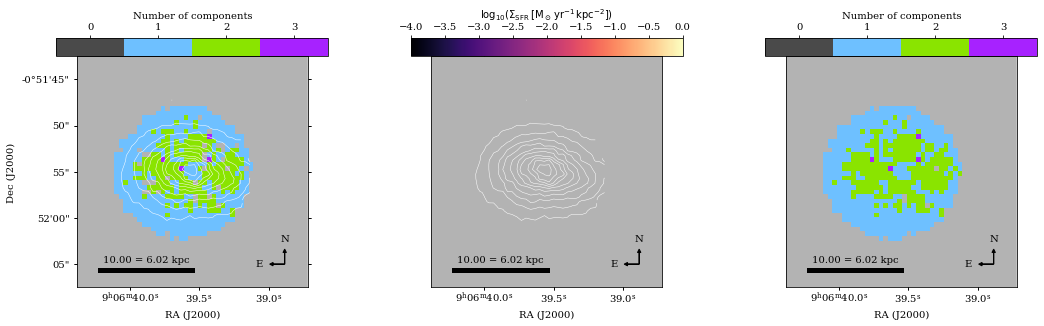

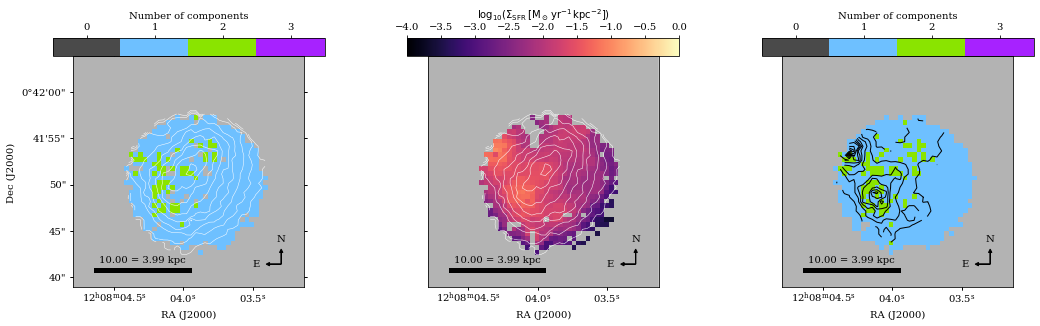

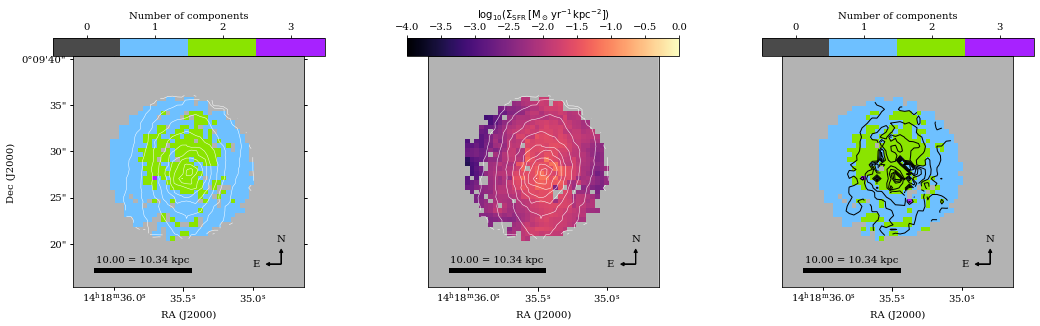

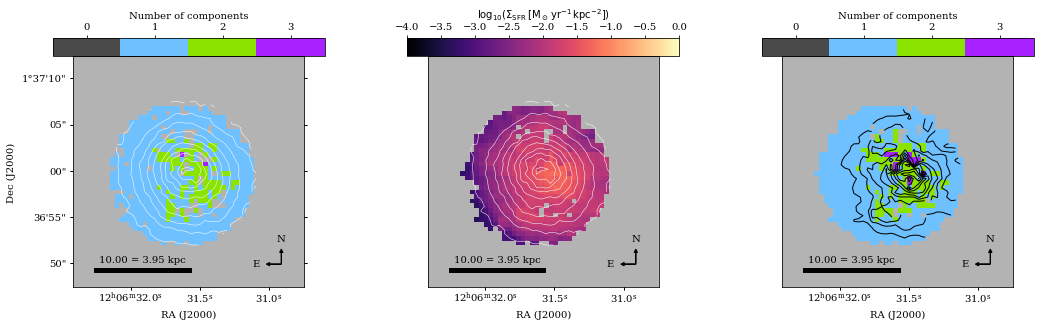

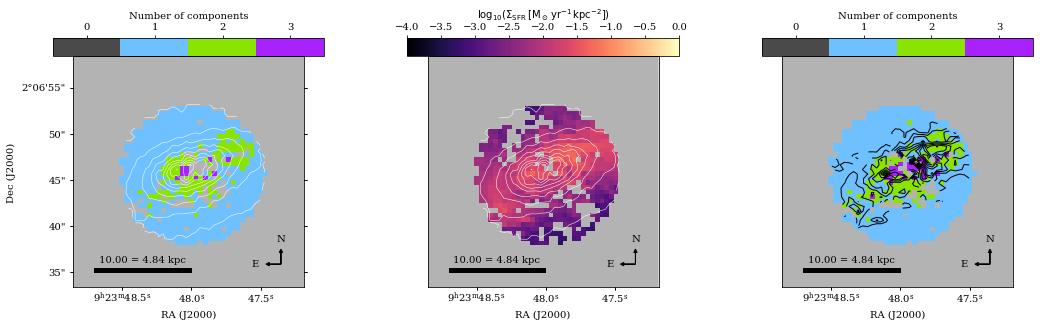

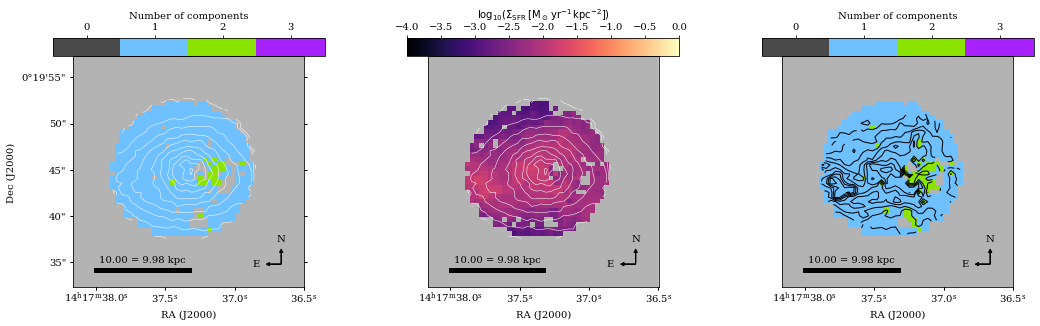

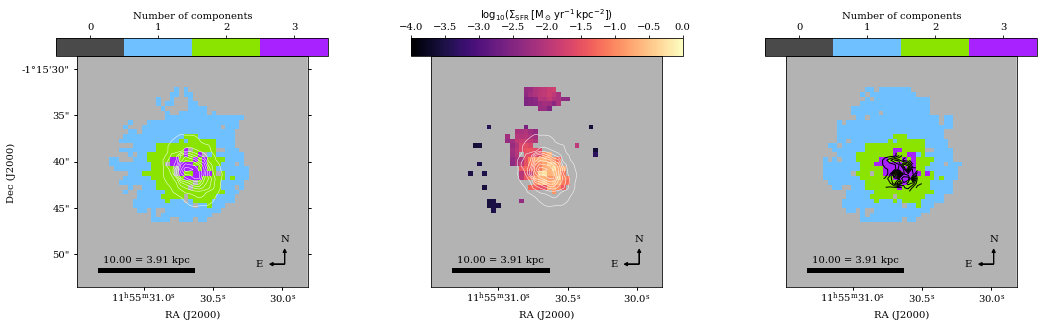

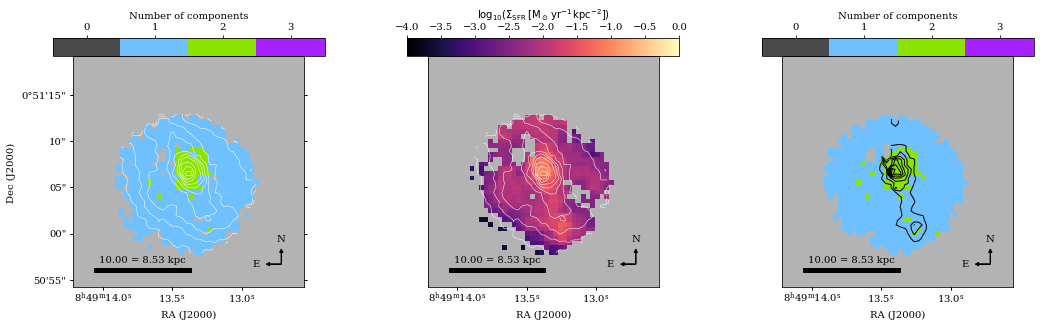

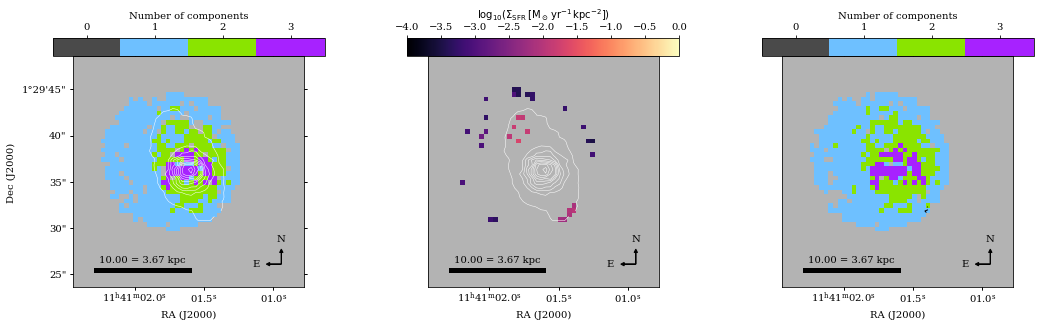

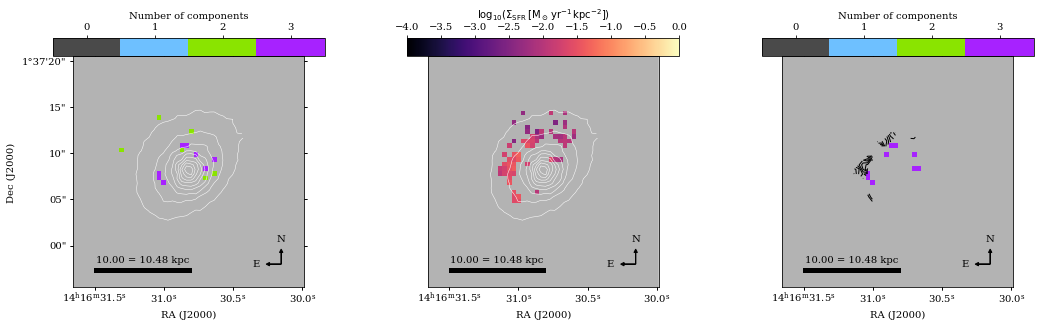

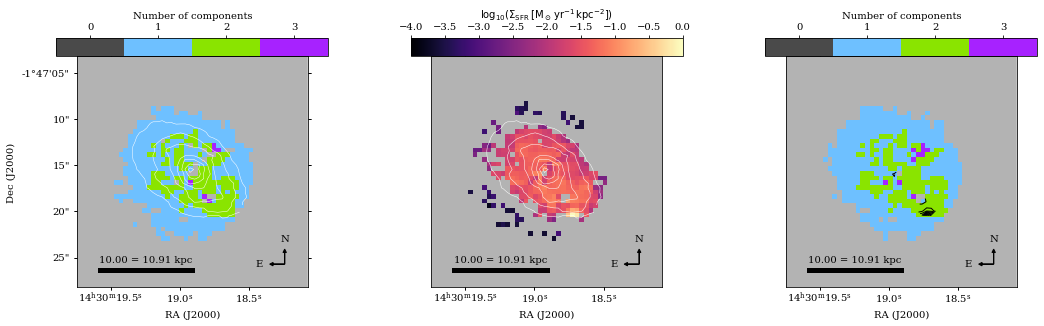

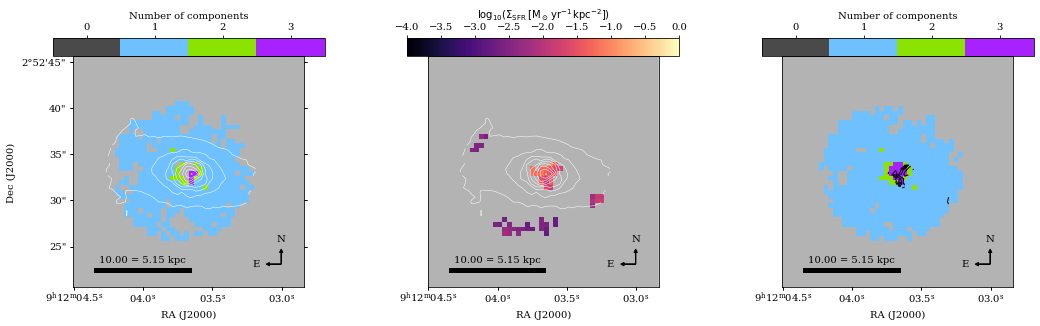

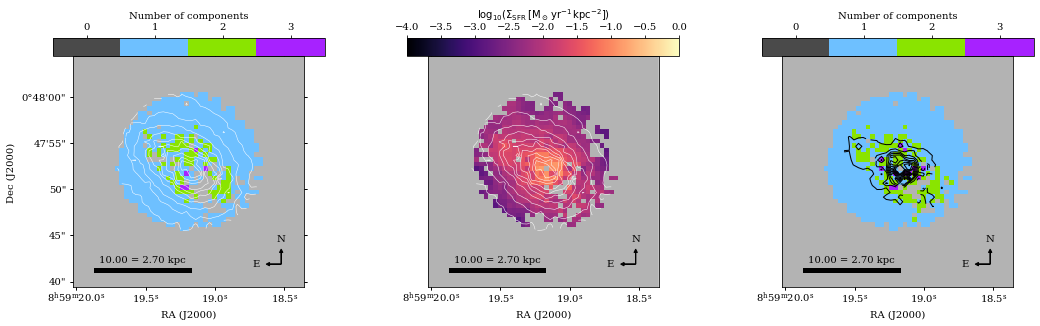

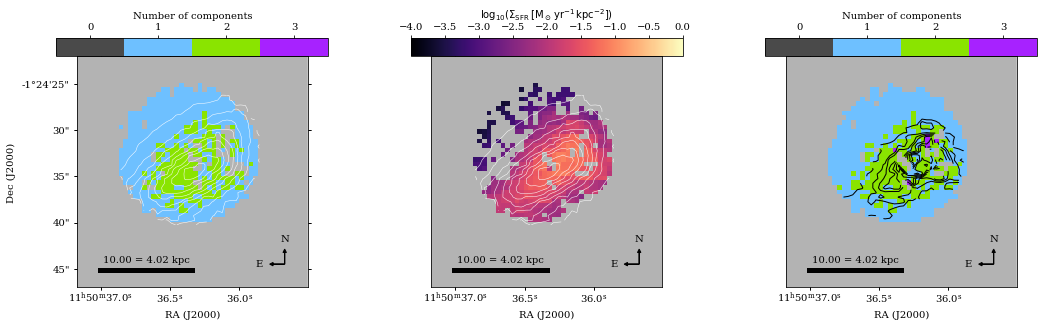

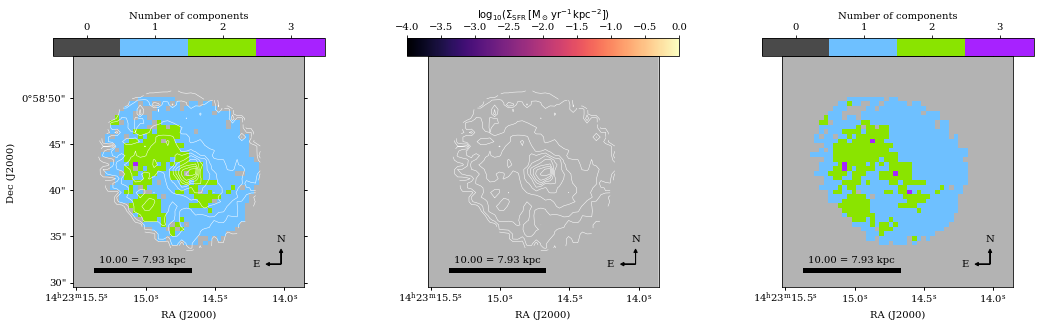

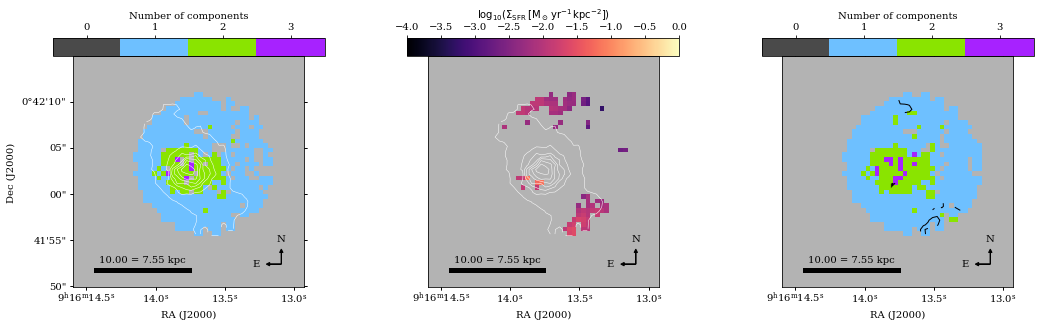

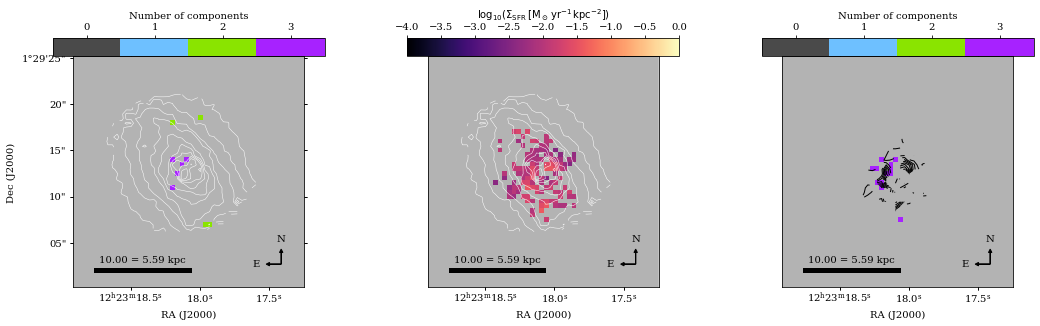

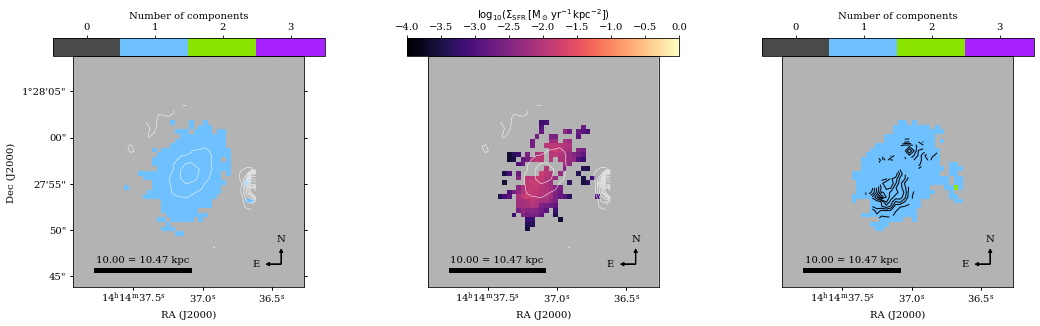

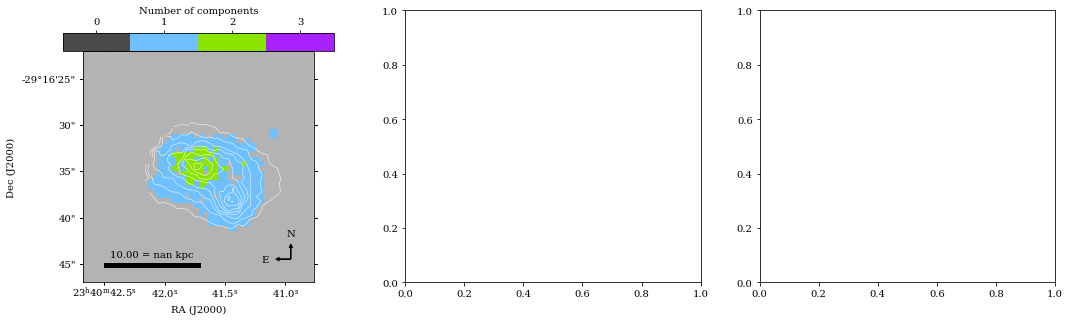

In [14]:
for gal in gals_good:
    # Load LZIFU data
    df_gal = load_lzifu_galaxy(gal=gal, bin_type="default", ncomponents="recom",
                       eline_SNR_min=5,
                       sigma_gas_SNR_cut=True,
                       vgrad_cut=False,
                       stekin_cut=False)
    df_gal.loc[df_gal["Number of components"] == 0, "Number of components"] = np.nan
    
    # Get SAMI data for this galaxy
    df_gal_sami = df_sami[df_sami["catid"] == gal]
    df_gal_sami.loc[df_gal_sami["Number of components"] == 0, "Number of components"] = np.nan

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

    # Number of components
    fig = plot2dmap(df_gal=df_gal, bin_type="default", survey="sami", 
                    col_z="Number of components", show_title=False, ax=axs[0],
                    plot_colorbar=True, cax_orientation="horizontal")

    # SFR surface density
    fig = plot2dmap(df_gal=df_gal_sami, bin_type="default", survey="sami", 
                    col_z="log SFR surface density", ax=axs[1], show_title=False, 
                    plot_colorbar=True, cax_orientation="horizontal")

    # Plot # of components overlaid with contours showing SFR surface density
    # NOTE: we use df_gal_sami here because the number of components is derived from SAMI DR3 anyway,
    # and log SFR surface density isn't defined in LZIFU
    fig = plot2dmap(df_gal=df_gal_sami,
                    bin_type="default", survey="sami", 
                    col_z="Number of components", show_title=False,  ax=axs[2],
                    col_z_contours="SFR surface density", linewidths=1, colors="black",
                    plot_colorbar=True, cax_orientation="horizontal")

    # Turn off axis labels
    axs = fig.get_axes()
    for ax in [axs[2], axs[4]]:
        lat = ax.coords[1]
        lat.set_ticks_visible(False)
        lat.set_ticklabel_visible(False)
